Epoch 10
Train accuracy: 0.99614
Val accuracy: 0.9773


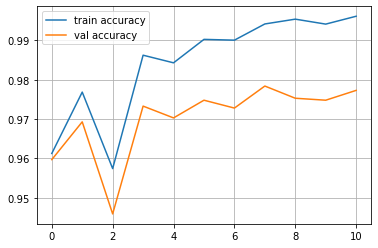

 96%|█████████████████████████████████████████████████████████████████████████▋   | 2989/3125 [00:12<00:00, 248.12it/s]

In [ ]:
import numpy as np
from tqdm import trange
from IPython.display import clear_output

class Layers(object):
  def __init__(self):
    pass
    
  class Dense(object):
    """
    A dense class whose object represents one layer of a
    fully connected nerual network.
    """
    def __init__(self, input_units, output_units, learning_rate=0.1):
      self.learning_rate = learning_rate
      self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
      self.biases = np.zeros(output_units)
        
    def forward(self,input):
      """
      Performs feed forward through the layer
      f(x) = <W*x> + b
        
      input shape: [batch, input_units]
      output shape: [batch, output units]
      """
      return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_incoming):
        """
        Performs backpropagation and calculating gradients for optimisation of weights

        input shape: [batch, input_units] , [batch, output units]
        output shape: [batch, input units]
        """
        grad_outgoing = np.dot(grad_incoming, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_incoming)
        grad_biases = grad_incoming.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent . 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_outgoing

class activation(object):
  def __init__(self):
    pass

  class ReLU(object):
      def __init__(self):
          """ReLU layer applies elementwise Rectified Linear Unit function to all inputs"""
          pass
    
      def forward(self, input):
          """Apply elementwise ReLU to [batch, input_units] matrix"""
          relu_forward = np.maximum(0,input)
          return relu_forward
    
      def backward(self, input, grad_output):
          """Compute gradient of loss w.r.t. ReLU input"""
          relu_grad = input > 0
          return grad_output*relu_grad

def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""

    logit_of_answer = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logit_of_answer + np.log(np.sum(np.exp(logits),axis=-1))
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    one_hot_vectors = np.zeros_like(logits)
    one_hot_vectors[np.arange(len(logits)),reference_answers] = 1

    exps = np.exp(logits-np.max(logits,axis=1,keepdims=True))    
    softmax = exps / exps.sum(axis=-1,keepdims=True)
    
    return (- one_hot_vectors + softmax) / logits.shape[0]

import tensorflow.keras as keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    """ A function to generate data. In this test run, MNIST hand written digits data is used.
      You can also replace this function to load your own data"""
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');
plt.show()

#Initialisation of Neural Network
network = []
network.append(Layers().Dense(X_train.shape[1],100))
network.append(activation().ReLU())
network.append(Layers().Dense(100,200))
network.append(activation().ReLU())
network.append(Layers().Dense(200,10))

def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input of next layer to be previous layer's output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
#A generator which yeilds batches of images and also shows a progress bar
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

from IPython.display import clear_output
train_log = []
val_log = []

#Main training loop which iterates though the mini batches
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=16,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))

    #Displaying training metrics
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
